In [116]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In [117]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report,confusion_matrix, roc_auc_score, precision_recall_curve, accuracy_score

In [118]:
filename = 'conversion_data.csv'
df = pd.read_csv(filename)
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,UK,25,1,Ads,1,0
1,US,23,1,Seo,5,0
2,US,28,1,Seo,4,0
3,China,39,1,Seo,5,0
4,US,30,1,Seo,6,0


In [119]:
df.describe(exclude = None)

,age,new_user,total_pages_visited,converted
count,316200.000000,316200.000000,316200.000000,316200.000000
mean,30.569858,0.685465,4.872966,0.032258
std,8.271802,0.464331,3.341104,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000


Here we can see, that the max age is 123, which seems a little improbable; lets see how many entries we have above the age of 100

In [120]:
df.loc[df.age >= 100]

,country,age,new_user,source,total_pages_visited,converted
90928,Germany,123,0,Seo,15,1
295581,UK,111,0,Ads,10,1


Only 2! Thats great, since we have 316200 entries, deleting 2 wont modify the data significantly

In [121]:
df = df.loc[df.age<100]

In [122]:
df.describe()

,age,new_user,total_pages_visited,converted
count,316198.000000,316198.000000,316198.000000,316198.000000
mean,30.569311,0.685469,4.872918,0.032252
std,8.268958,0.464329,3.341053,0.176669
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,79.000000,1.000000,29.000000,1.000000


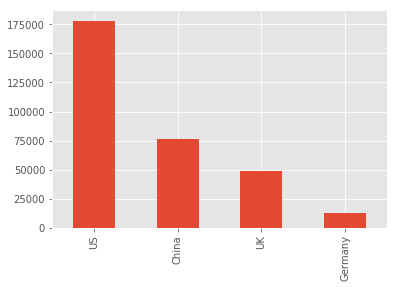

In [123]:
country_dist = df.country.value_counts()
country_dist.plot(kind='bar')

In [124]:
conv_country_dist = df[['country','converted']].groupby('country').agg(['mean','count'])
conv_country_dist

converted        
             mean   count
country                  
China    0.001332   76602
Germany  0.062428   13055
UK       0.052612   48449
US       0.037801  178092

From this table, we can see that there are a lot of users from China, but a poor conversion rate; little users from Germany, but good conversion rate (relatively)

From this we can make the conclusion that there is a problem with Chinese users on the site.

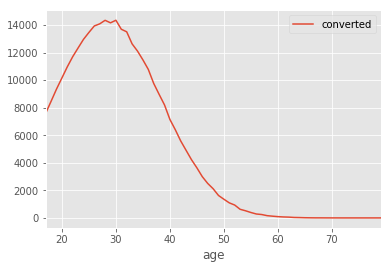

In [125]:
df[['age','converted']].groupby('age').agg('count').plot()

From this plot we can see that the conversion rate is high, and peaks, for our younger users, and decreases drastically as age increases after our 30 year old peak

Last, we want to see how the total pages visited affects the conversion rate

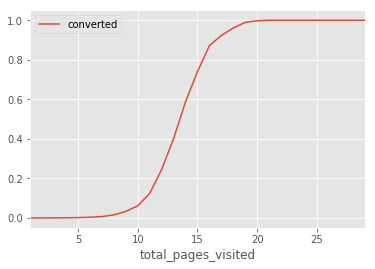

In [135]:
df[['total_pages_visited','converted']].groupby('total_pages_visited').agg('mean').plot()

From this plot we can see that typically, the more pages a user views, the more likely they are to convert(buy something).

In [136]:
df = pd.get_dummies(df)
df.head()

,age,new_user,total_pages_visited,converted,country_China,country_Germany,country_UK,country_US,source_Ads,source_Direct,source_Seo
0,25,1,1,0,0,0,1,0,1,0,0
1,23,1,5,0,0,0,0,1,0,0,1
2,28,1,4,0,0,0,0,1,0,0,1
3,39,1,5,0,1,0,0,0,0,0,1
4,30,1,6,0,0,0,0,1,0,0,1


In [143]:
X = df.drop('converted',axis = 1)
Y = df.converted.values